# von Bertalanffy growth model for Chagos *P. lacrymatus*


In [1]:
# Import python packages
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pymc3 as pm
from pymc3.backends import SQLite
import theano as th
import theano.tensor as tt
import seaborn as sns
import matplotlib as mp
import pdb


/Users/aaronmacneil/anaconda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# Helper functions
def indexall(L):
    poo = []
    for p in L:
        if not p in poo:
            poo.append(p)
    Ix = np.array([poo.index(p) for p in L])
    return poo,Ix

def subindexall(short,long):
    poo = []
    out = []
    for s,l in zip(short,long):
        if not l in poo:
            poo.append(l)
            out.append(s)
    return indexall(out)

def firstindex(L):
    ulist = unique(L)
    return np.array([poo.index(p) for p in ulist])

match = lambda a, b: np.array([ b.index(x) if x in b else None for x in a ])

In [3]:
# Import age and growth data
xdata = pd.read_csv('chagos_otolith.csv')

In [4]:
xdata.head()

,Atoll,Site,Treatment,Fish Species,OtolithID,Otolith_weight,TL,FL,SL,Age,Radius,Annulus1
0,Great Chagos Bank,South Brother,No rats,Plectroglyphidodon lacrymatus,H9,0.0081,10.0,8.6,7.0,3,35461.227,16752.711
1,Great Chagos Bank,Eagle,Rats,Plectroglyphidodon lacrymatus,T1,0.0057,8.3,7.3,5.9,2,28383.250,13475.520
2,Great Chagos Bank,Eagle,Rats,Plectroglyphidodon lacrymatus,T2,0.0049,7.6,6.5,5.1,2,22370.652,13786.116
3,Great Chagos Bank,Eagle,Rats,Plectroglyphidodon lacrymatus,T3,0.0072,8.4,7.4,6.1,3,34709.871,20003.127
4,Great Chagos Bank,Eagle,Rats,Plectroglyphidodon lacrymatus,T4,NaN,8.6,7.6,6.2,2,27467.670,18144.131


In [5]:
# Site
site = xdata.Site.values

# Fish ID
ID = xdata.OtolithID.values

# Length
TL = xdata.TL.values
lTL = np.log(TL)
maxTL = max(TL)
minTL = min(TL)

# Bird or rat island
Treatment,It = indexall(xdata.Treatment.values)

# Age
age = xdata.Age.values

# Plotting age
agex = np.linspace(min(age),max(age),num=100)

In [6]:
Treatment

['No rats', 'Rats']

In [7]:
Model = pm.Model()

with Model:
    Linf = pm.Uniform('Linf',maxTL, maxTL*2)
    L0 = pm.Uniform('L0', 0, minTL)
    k0 = pm.Uniform('k0', 0.001, 1)
    k1 = pm.Normal('k1', 0, 10)
    σ = pm.Uniform('σ', 0, 1000)
    μ = tt.log(Linf-(Linf-L0)*tt.exp(-(k0+k1*It)*age))
    yi = pm.Normal('yi',μ, σ, observed=lTL)

In [8]:
with Model:
    trace = pm.sample(5000, progressbar=True, jobs=2);

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/Users/aaronmacneil/anaconda/lib/python3.6/site-packages/pymc3/model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
100%|██████████| 5500/5500 [00:20<00:00, 262.21it/s]/Users/aaronmacneil/anaconda/lib/python3.6/site-packages/pymc3/step_methods/hmc/nuts.py:451: UserWarning: The acceptance probability in chain 0 does not match the target. It is 0.8816867992697087, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))
/Users/aaronmacneil/anaconda/lib/python3.6/site-packages/pymc3/step_methods/hmc/nuts.py:467: UserWarning: Chain 0 contains 1 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_divergin

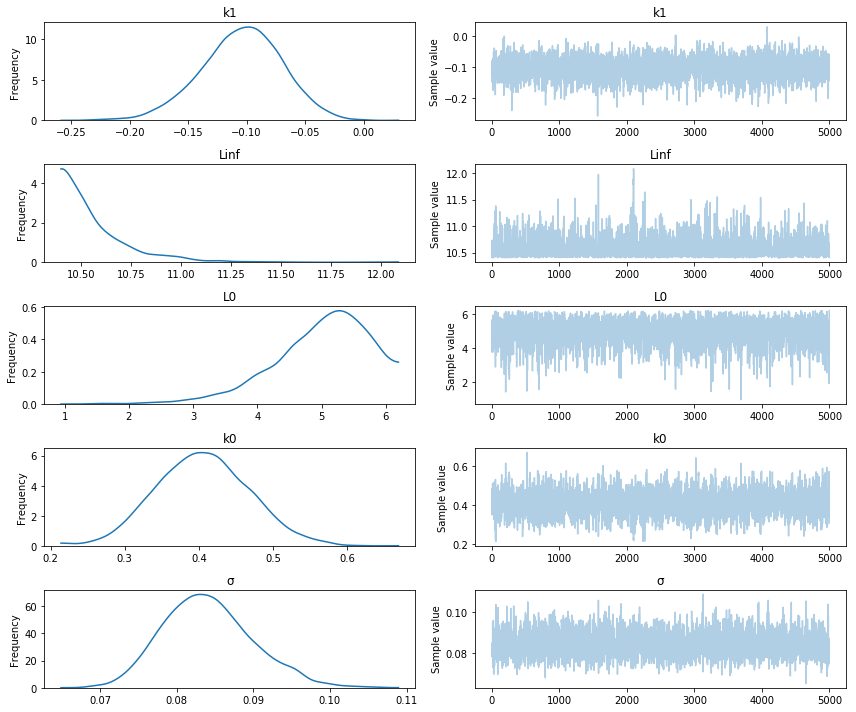

In [9]:
pm.traceplot(trace);

In [10]:
minTL, maxTL

(6.2, 10.4)

In [11]:
# Export results 
out = pm.backends.tracetab.trace_to_dataframe(trace)
colnames = np.array(list(out.columns), dtype=object)

In [12]:
out.head()

,k1,Linf,L0,k0,σ
0,-0.120132,10.500492,4.592864,0.446496,0.082652
1,-0.121676,10.451500,5.115884,0.427511,0.079595
2,-0.104574,10.725854,4.588277,0.406974,0.078156
3,-0.087380,10.635803,5.089446,0.368076,0.081244
4,-0.118741,10.434561,4.641925,0.464066,0.078527


In [13]:
out.to_csv('vonB_results.csv')

In [14]:
out.quantile([.025,.25,.5,.75,.975])

,k1,Linf,L0,k0,σ
0.025,-0.175892,10.404350,3.229989,0.288147,0.073733
0.250,-0.126127,10.451854,4.552199,0.362109,0.079909
0.500,-0.102648,10.520376,5.089733,0.405043,0.083672
0.750,-0.080455,10.644863,5.517914,0.447413,0.087670
0.975,-0.039790,11.063599,6.101861,0.532567,0.096250
